In [1]:
#! /usr/bin/env python3

# Takes as input a file "DeltaT.txt.gz"

import gzip
import numpy as np
from matplotlib import pyplot as plt

import sys
import seaborn as sns

import pickle

#sns.set_context("paper", rc={"font.size":22,"axes.titlesize":18,"axes.labelsize":26})   
sns.set(font_scale=1.5)
sns.set_style("darkgrid",
              {'grid.linestyle': '--',  'grid.color': 'lightgrey'})
plt.rcParams.update({'font.size': 16})

In [2]:
hasattr(sys, 'ps1')

True

In [3]:
import ast

In [4]:
if not hasattr(sys, 'ps1'):
    
    import argparse
    parser = argparse.ArgumentParser("Plot distribution from file, mainly for Intervals")
    
    parser.add_argument('-f', '--file', default="Intervals.txt.gz", 
                        help="Gzipped file to read from, Intervals.txt.gz, ignored if obs-id/channel")
    parser.add_argument('-o', '--obs-id', help="Observation ID of file")
    parser.add_argument('-c', '--channel', help="Telescope Channel of file")
    parser.add_argument('-r', '--range', default='[0, 0]', help="Range [min, max] for plot, default from plot")
    parser.add_argument('-b', '--bins', default=10, type=int, help="Number of bins, default 10 or range if -1, max 1000")
    #parser.add_argument('-l', '--log', default=True, type=bool, help="Plot with symlog y-scale")
    parser.add_argument('-l','--log', default=True, action=argparse.BooleanOptionalAction)
    parser.add_argument('-n', '--num', default=0, type=str, help="Number of events to plot, or range, default all, ")
    parser.add_argument('-t', '--title', default='', help="Title for plot")
    parser.add_argument('--cartouche', default='best',help="Legend location") 
    parser.add_argument('-y','--ymax',default=None, type=int, help="Maximum of y-axis scale")
    
    
    args = parser.parse_args()

    if args.obs_id and args.channel:
        obsid = args.obs_id
        tel = args.channel
        fname = fname = f"outputs/{obsid}_tel_{tel}.intervals.gz"
    else:
        fname = args.file
    pltrange = ast.literal_eval(args.range)
    #print(args.num)
    numrange = ast.literal_eval(args.num)
    #print(numrange,type(numrange))
    if type(numrange) != list:
        if numrange == 0:
            numrange = [0,np.inf]
        else:
            numrange = [0,numrange]
    #print(numrange,type(numrange))

    log = args.log
    if args.title != '':
        newtitle = args.title
    else:
        newtitle = f"ObsID {obsid} Telescope {tel}"
    num = args.num
    bins = args.bins
    loc = args.cartouche
    ymax = args.ymax
    
else:

    obsid = 91
    tel = 25
    fname = f"outputs/{obsid}_tel_{tel}.intervals.gz"
    pltrange = [0,20000]
    log = True
    newtitle = f"ObsID {obsid} Telescope {tel}"
    numrange = [0,100000]
    bins = 100
    loc = "best"
    ymax = None

In [5]:
from scipy.optimize import curve_fit

def func(x, a, b, c):
    return a * np.exp(-b * x) + c



In [6]:
from itertools import pairwise

In [7]:
if not (pltrange[0]==0 and pltrange[1]==0) and bins==-1: # Range is specified, but not bins
    bins = min(pltrange[1]-pltrange[0]+1,1000)
elif not (pltrange[0]==0 and pltrange[1]==0): # Range is specified, and also bins
     bins = bins
elif (pltrange[0]==0 and pltrange[1]==0) and bins==-1: # Range is unspecified, but bins are
     bins = bins
else:
    bins = 1000

print("Range, symlog, Title, bins:, evtrange:",pltrange,log,newtitle,bins,numrange)

Range, symlog, Title, bins:, evtrange: [0, 20000] True ObsID 91 Telescope 25 100 [0, 100000]


In [8]:
Deltas = []
t1000s = []
with gzip.open(fname,"rt") as f:
    next(f) # Skip first line which is info message
    next(f) # Skip 2nd line which is info message
    #Intervals = list(map(int,f.read(100000000).splitlines()))

    nline = 0

    while nline < numrange[1]:
        # Read DeltaT, DeltaReadout, DeltaBusy
        try:
            l = next(f)
        except Exception as e:
            print(e)
            if e == "EOFError":
                break
            elif e == "StopIteration":
                break
            else:
                print("Uncaught exception",e)
                break
            
        nline += 1
        if nline < numrange[0]:
           continue
            
        #print(l)
        Delta = [int(i) for i in l.split()[0:5]]
        Delta = np.array(Delta)
        Deltas.append(Delta)

        if (nline-1)%1000 == 0:
            t1000s.append(Delta[4])
          
Deltas = np.array(Deltas)

print("\nNumber of Events",len(Deltas))
print()


Number of Events 100000



In [9]:
t1000s = np.array(t1000s)

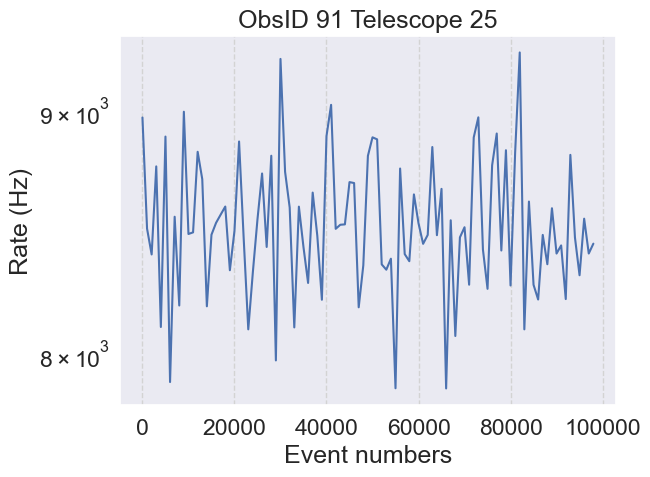

In [12]:
plt.title(newtitle)
plt.plot(numrange[0]+np.array(range(len(t1000s)-1))*1000,(t1000s[1:]-t1000s[:-1])/1000)
plt.ylabel("Rate (Hz)")
plt.xlabel("Event numbers")
plt.yscale("log")
plt.savefig(f"outputs/{obsid}_tel_{tel}_{numrange}_rates.png")
plt.show()

Using range [0, 20000] with 100 bins.

In histogram:
         91213  All Events
None
Rate: 27589.7 Hz


/tmp/ipykernel_1068461/3154804.py:37: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(ymin=0)


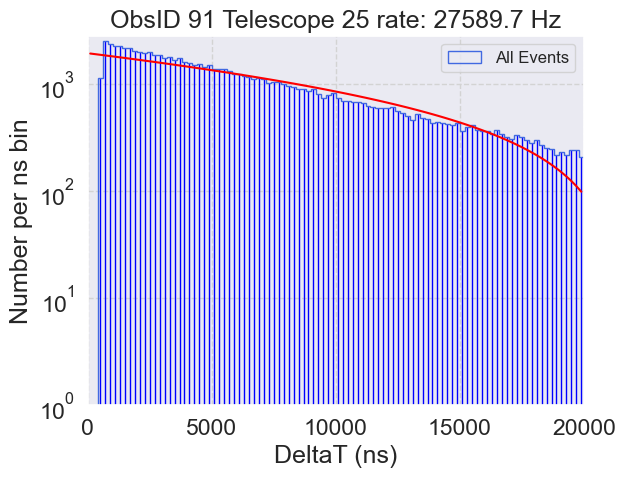

In [13]:
plt.figure()

if not (pltrange[0]==0 and pltrange[1]==0):
    print("Using range",pltrange,"with",bins,"bins.")
    n,bin_edges,_ = plt.hist(Deltas[:,0], range=pltrange, bins=bins,histtype='step',lw=3,color='royalblue',label="All Events")
    print("\nIn histogram:")
    print(f"    {sum(n):10.0f}  All Events")
    plt.xlim(pltrange)
else:
    print("No range given, using auto")
    n,bin_edges,_ = plt.hist(Deltas[:,0], bins=bins, histtype='step',lw=4,color='royalblue',label="All Events")
    print("\nIn histogram:")
    print(f"    {sum(n):10.0f}  All Events")
    plt.xlim(xmin=0)

#n,bin_edges,_ = plt.hist(Deltas[Deltas[:,1]==0,0], bins=bin_edges,histtype='step',ls=':',lw=1,color='purple',label="Neither")

plt.legend(prop={'size': 12}, loc=loc)


#plt.grid()

if log:
    #plt.yscale('symlog')
    #plt.ylim(bottom=1)
    plt.yscale('log')
    plt.ylim(ymin=1)
    
print(ymax)
if ymax is not None:
    plt.ylim(ymax=ymax)
    
plt.xlabel("DeltaT (ns)")
plt.ylabel("Number per ns bin")
#plt.tight_layout()

plt.ylim(ymin=0)


x = np.mean(list(pairwise(bin_edges)),axis=1)
plt.bar(x,n, color="red",edgecolor="blue")
#plt.yscale("log")

try:
    popt, pcov = curve_fit(func, x, n,p0=[max(n),1/16_000,0])
    plt.plot(x,func(x,*popt),color="red")
    rate = f"{(1/popt[1]):.1f}"
except:
    rate = "no fit"

print(f"Rate: {rate} Hz")


plt.yscale('log')

plt.title(newtitle+f" rate: {rate} Hz") # bbox=dict(facecolor='grey', alpha=0.5)))

'''
popt, pcov = curve_fit(func, x[3:20], n[3:20],p0=[max(n),1/16_000,0])
plt.plot(x,func(x,*popt))
plt.yscale('log')
print(f"Rate: {(1/popt[1]):.1f} Hz")
'''

plt.yscale('log')

plt.savefig(f"outputs/{obsid}_tel_{tel}_{numrange}_deltas.png")

plt.show()

In [14]:
Delta

array([               1483,                   1,                   0,
                2478137933, 1748938318543071191])

In [15]:
Deltas[:,1]

array([1, 1, 1, ..., 1, 1, 1])

In [16]:
print(num_lost:=np.sum(Deltas[:,1]-1),"events lost out of ",num_evts:=np.sum(Deltas[:,1]),
      f"so {100*num_lost/num_evts:.2f}%")

0 events lost out of  100000 so 0.00%


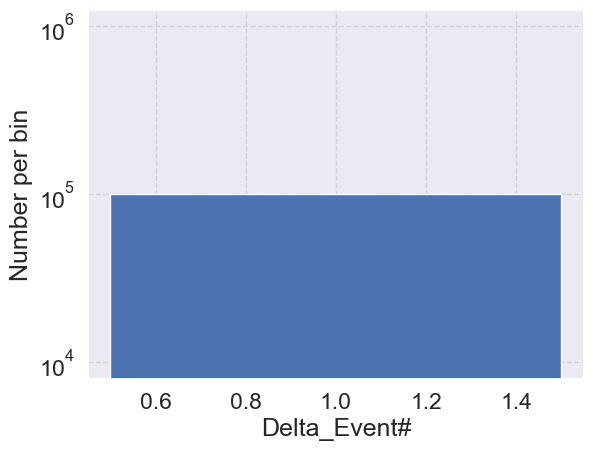

array([100000.])

In [17]:

bins = min(40,max(Deltas[:,1]))
h = plt.hist(Deltas[:,1],bins=bins)
plt.yscale("log")
plt.xlabel("Delta_Event#")
plt.ylabel("Number per bin")

plt.show()
h[0]